In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')

## Loading the data

The dataset is stored in a CSV file. I'll load it and take a quick look at what's inside.

In [2]:
data = pd.read_csv('Dataset.csv')

print(f"Dataset shape: {data.shape}")
print(f"\nColumn names:\n{data.columns.tolist()}")
data.head()

Dataset shape: (10000, 10)

Column names:
['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target', 'Failure Type']


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


The dataset has no missing values. The target column is labeled 'Target' where 0 means no failure and 1 means failure occurred.

In [4]:
print(data['Target'].value_counts())
print(f"\nFailure rate: {data['Target'].mean():.3f}")

Target
0    9661
1     339
Name: count, dtype: int64

Failure rate: 0.034


The dataset is imbalanced, with failures being much less common than normal operations. This is expected in industrial settings where failures are rare events.

## Preprocessing

Some columns need to be removed or transformed before training a model.

The UDI and Product ID columns are just identifiers with no predictive value. The Failure Type column describes what kind of failure happened, but this information would only be known after a failure occurs, so it cannot be used for prediction. I'm removing all three of these columns.

In [5]:
data_clean = data.drop(columns=['UDI', 'Product ID', 'Failure Type'])
data_clean.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,M,298.1,308.6,1551,42.8,0,0
1,L,298.2,308.7,1408,46.3,3,0
2,L,298.1,308.5,1498,49.4,5,0
3,L,298.2,308.6,1433,39.5,7,0
4,L,298.2,308.7,1408,40.0,9,0


The Type column is categorical with values L, M, and H. Since there are only three values and they appear to have an ordinal relationship, I'll map them to numbers.

In [6]:
type_mapping = {'L': 0, 'M': 1, 'H': 2}
data_clean['Type'] = data_clean['Type'].map(type_mapping)

print(data_clean['Type'].value_counts().sort_index())

Type
0    6000
1    2997
2    1003
Name: count, dtype: int64


Now I'll separate the features from the target variable.

In [7]:
X = data_clean.drop(columns=['Target'])
y = data_clean['Target']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {X.columns.tolist()}")

Features shape: (10000, 6)
Target shape: (10000,)

Feature columns: ['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']


## Train-test split

I'll split the data into training and testing sets. The stratify parameter ensures that both sets have roughly the same proportion of failures, which is important for an imbalanced dataset.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nFailure rate in training set: {y_train.mean():.3f}")
print(f"Failure rate in test set: {y_test.mean():.3f}")

Training set: 8000 samples
Test set: 2000 samples

Failure rate in training set: 0.034
Failure rate in test set: 0.034


## Feature scaling

Logistic regression works better when features are on similar scales. I'll use StandardScaler to normalize the features so they have mean 0 and standard deviation 1.

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully")

Features scaled successfully


## Model choice

I'm using logistic regression for this task. The problem is a binary classification with structured tabular data, and logistic regression is well-suited for this. It's interpretable, meaning we can understand which features contribute most to predictions, and it's simple enough to avoid overfitting on a dataset of this size. The class_weight parameter is set to 'balanced' to handle the imbalance between failure and non-failure cases.

In [11]:
model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

print("Model trained successfully")

Model trained successfully


## Making predictions

Now I'll use the trained model to predict failures on the test set.

In [12]:
y_pred = model.predict(X_test_scaled)

print(f"Predictions made for {len(y_pred)} test samples")

Predictions made for 2000 test samples


## Evaluation

I'll evaluate the model using several metrics. For this problem, recall is particularly important because missing a failure (false negative) is more costly than a false alarm (false positive).

In [13]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Model Performance:")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-score:  {f1:.3f}")

Model Performance:
Accuracy:  0.821
Precision: 0.139
Recall:    0.824
F1-score:  0.238


Precision tells us what fraction of predicted failures were actually failures. Recall tells us what fraction of actual failures the model caught. The F1-score balances both metrics.

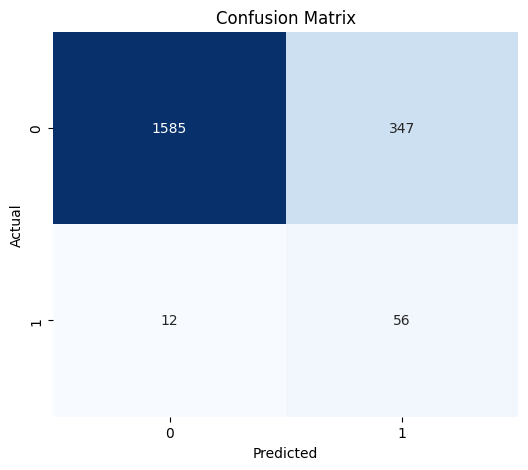


True Negatives:  1585
False Positives: 347
False Negatives: 12
True Positives:  56


In [14]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(f"\nTrue Negatives:  {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives:  {cm[1,1]}")

The confusion matrix shows how many predictions were correct or incorrect in each category. False negatives are the cases where the model predicted no failure but a failure actually occurred. These are the most important errors to minimize in a maintenance setting.

In [15]:
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Failure', 'Failure']))


Detailed Classification Report:
              precision    recall  f1-score   support

  No Failure       0.99      0.82      0.90      1932
     Failure       0.14      0.82      0.24        68

    accuracy                           0.82      2000
   macro avg       0.57      0.82      0.57      2000
weighted avg       0.96      0.82      0.88      2000



## Feature importance

Looking at the model coefficients helps understand which features have the strongest influence on predictions. Positive coefficients increase the probability of failure, while negative coefficients decrease it.

                Feature  Coefficient
            Torque [Nm]     2.403984
    Air temperature [K]     1.777107
 Rotational speed [rpm]     1.727852
Process temperature [K]    -1.230404
        Tool wear [min]     0.865778
                   Type    -0.213427


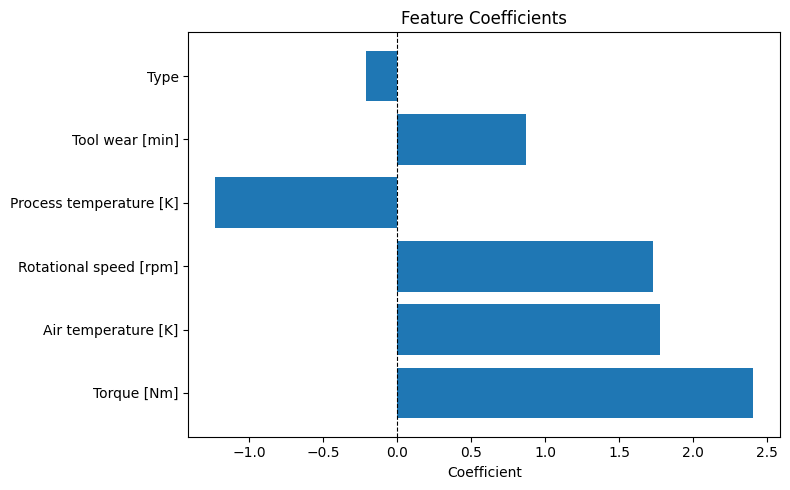

In [16]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print(feature_importance.to_string(index=False))

plt.figure(figsize=(8, 5))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'])
plt.xlabel('Coefficient')
plt.title('Feature Coefficients')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

## Summary

The logistic regression model provides a simple baseline for predicting machine failures. The model achieves reasonable performance on this imbalanced dataset by using class weights to give more importance to the minority failure class.

The evaluation shows how well the model balances between catching failures and avoiding false alarms. In a real deployment, the threshold for making predictions could be adjusted based on the relative costs of missed failures versus unnecessary maintenance checks.

Although the dataset contains different failure types, the task focuses only on predicting whether a failure occurs, so all failure categories are treated as a single class.